In [1]:
import h5py

In [2]:
f = h5py.File('/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo/IWCDmPMT_4pi_full_tank_e-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_1.h5','r')
event_data = f['event_data'][:]

In [3]:
from __future__ import print_function
import numpy as np

In [4]:
f.keys()

<KeysViewHDF5 ['directions', 'energies', 'event_data', 'event_ids', 'labels', 'mGridDirX', 'mGridDirY', 'mGridDirZ', 'mGridPmt', 'mGridX', 'mGridY', 'mGridZ', 'pids', 'positions']>

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

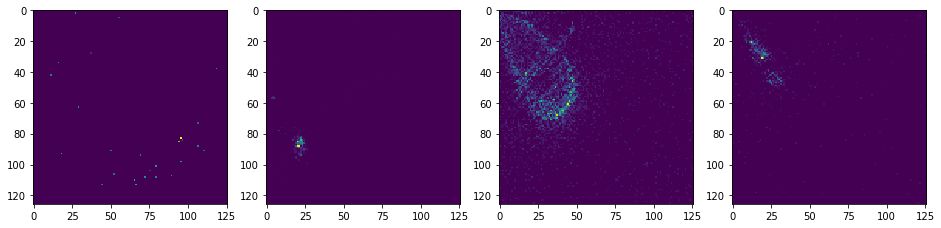

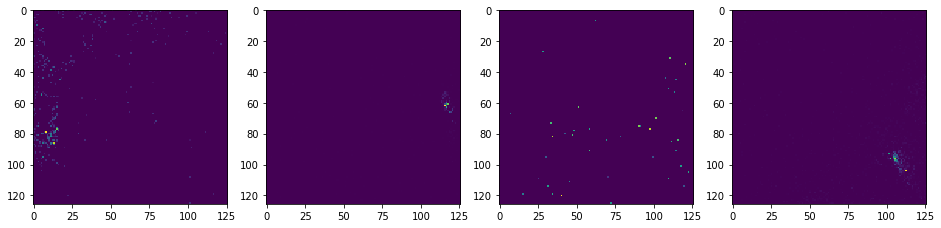

In [6]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data[0,:,:,0])
ax1.imshow(event_data[1,:,:,0])
ax2.imshow(event_data[2,:,:,0])
ax3.imshow(event_data[3,:,:,0])
plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data[4,:,:,0])
ax1.imshow(event_data[5,:,:,0])
ax2.imshow(event_data[6,:,:,0])
ax3.imshow(event_data[7,:,:,0])
plt.show()

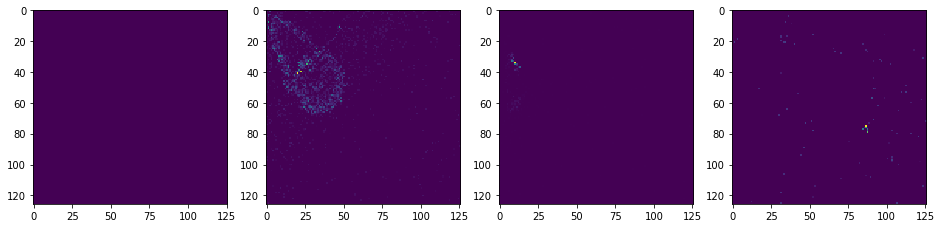

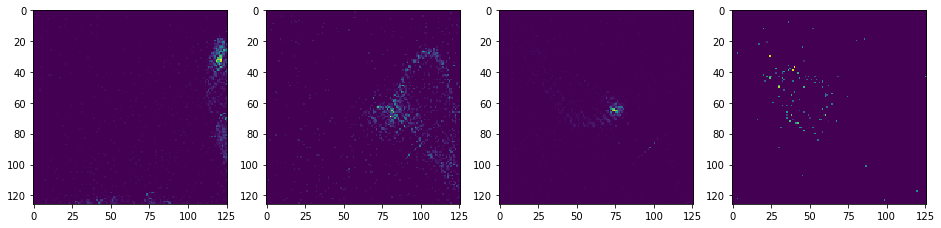

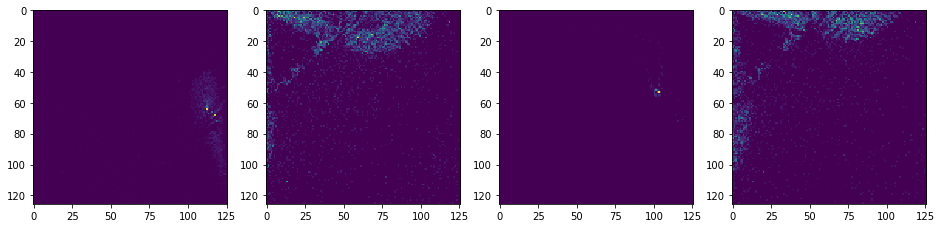

In [14]:
f1Rmu = h5py.File('/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo/IWCDmPMT_4pi_full_tank_mu-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_1.h5','r')
event_data_1Rmu = f1Rmu['event_data'][:]

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data_1Rmu[0,:,:,0])
ax1.imshow(event_data_1Rmu[1,:,:,0])
ax2.imshow(event_data_1Rmu[2,:,:,0])
ax3.imshow(event_data_1Rmu[3,:,:,0])
plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data_1Rmu[4,:,:,0])
ax1.imshow(event_data_1Rmu[5,:,:,0])
ax2.imshow(event_data_1Rmu[6,:,:,0])
ax3.imshow(event_data_1Rmu[7,:,:,0])
plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data_1Rmu[8,:,:,0])
ax1.imshow(event_data_1Rmu[9,:,:,0])
ax2.imshow(event_data_1Rmu[10,:,:,0])
ax3.imshow(event_data_1Rmu[11,:,:,0])
plt.show()

In [7]:
import torch 

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

In [8]:
# M: number of cols or rows grid

pad = 2

mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
  f['mGridX'][()],
  f['mGridY'][()],
  f['mGridZ'][()],
  f['mGridDirX'][()],
  f['mGridDirY'][()],
  f['mGridDirZ'][()]
])
Ncoords = mGridCoord.shape[0]

M = mGridPmt.shape[0]
mGridI = np.reshape(np.repeat(np.arange(M),M), (M,M))
mGridJ = mGridI.transpose()

Nshift = 2*pad+1
dij = np.reshape(np.repeat(np.arange(-pad,pad+1),Nshift), (Nshift,Nshift));
dis = dij.flatten()
djs = dij.transpose().flatten();
Nsites = dis.size;

mGridPmtpad = geometricPad(torch.tensor(mGridPmt).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
mGridIpad = geometricPad(torch.tensor(mGridI).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
mGridJpad = geometricPad(torch.tensor(mGridJ).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();

mGridCoordPad = geometricPad(torch.tensor(mGridCoord).unsqueeze(0), pad).squeeze(0).numpy();


mGridAA2 = np.zeros((M,M,Nshift,Nshift,1+Ncoords)) # 1+Ncoords needs to be extended if we include 2nd order deriv

pmtI1 = mGridPmt[:,:]; # index in tank.pmt

x      = np.zeros((Ncoords,M,M,Nsites));     # coordinates for each direction
skip   = np.zeros((M,M,Nsites), dtype=bool); # for each direction whether we should skip or not
processedPmtI2s = np.zeros((M,M,Nsites), dtype=int) - 1;

for diji in range(Nsites):
    di = dis[diji]
    dj = djs[diji]
    i2 = mGridIpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
    j2 = mGridJpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
    pmtI2 = mGridPmtpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
    processedPmtI2s[:,:,diji] = pmtI2;
    
    skip[:,:,diji] = np.logical_or(np.equal(pmtI1,-1), np.equal(pmtI2,-1));
    for prev_diji in range(diji):
        skip[:,:,diji] = np.logical_or(skip[:,:,diji], np.equal(processedPmtI2s[:,:,prev_diji],pmtI2));
    
    x[:,:,:,diji] = mGridCoordPad[:,pad+di:pad+M+di,pad+dj:pad+M+dj] - mGridCoord; # 

# x: (Ncoords,M,M,Nsites)
print('x.shape:', x.shape)
# X: (Ntaylor,M,M,Nsites)    Ntaylor = 1 + Ncoords
X = np.concatenate([np.expand_dims(np.ones(x.shape[1:]),0),x])
print('X.shape:', X.shape)
X = np.where(np.expand_dims(skip, 0), 0., X);
# if we also do second derivatives, X needs to be extended by a x*x term

# regularization strength
Lambda = 1.; # this should be somewhat smaller than typical values of x

MA = np.zeros((M,M,Nsites,Nsites));
for k in range(Nsites):
    for j in range(Nsites):
        MA[:,:,k,j] = np.add(np.sum(x[:,:,:,k]*x[:,:,:,j], axis=0), 1. + Lambda**2 * (k==j));
    # clear skip entries
    MA[:,:,k,:] = np.where(np.expand_dims(skip[:,:,k],-1), 0., MA[:,:,k,:]);
    MA[:,:,:,j] = np.where(np.expand_dims(skip[:,:,j],-1), 0., MA[:,:,:,j]);
    # set diagonal:
    MA[:,:,k,k] = np.where(skip[:,:,k], 1., MA[:,:,k,k]);

#print('MA.shape:',MA.shape)
#print(MA[0,1,:,:])
#print(np.linalg.inv(MA[0,1,:,:]))
print("starting inversion... (may take a few seconds)")
AA = np.einsum('hwsi,thwi->thws', np.linalg.inv(MA), X)
print("done")
print('AA.shape:', AA.shape)

x.shape: (6, 126, 126, 25)
X.shape: (7, 126, 126, 25)
starting inversion... (may take a few seconds)
done
AA.shape: (7, 126, 126, 25)


that was *way* faster

tGridAA.shape: torch.Size([7, 126, 126, 25])
tayloredInput.shape: torch.Size([5, 7, 1, 126, 126])
inputsPad.shape: torch.Size([5, 1, 130, 130])


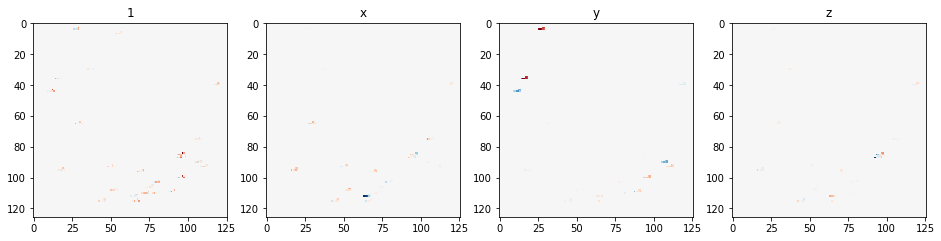

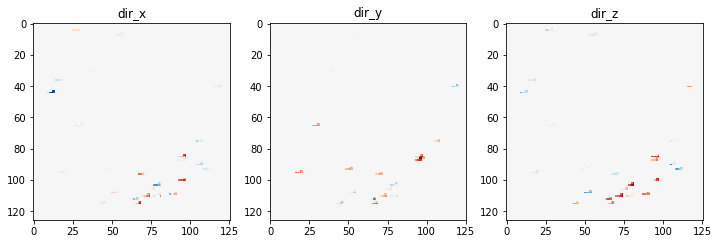

In [9]:
mGridAA = AA

Cin = 1; # Q
Hin = event_data.shape[1];
Win = event_data.shape[2];

# Cout = 4;
# Hflt = 2*pad+1;
# Wflt = 2*pad+1;

# filters = torch.randn(Cout,Cin,Hflt,Wflt);
inputs = torch.tensor(event_data[0:5,:,:,0]).unsqueeze(1);
# outputs = torch.nn.functional.conv2d(geometricPad(inputs, pad), filters);

# print('filters.shape = ', filters.shape, 'should be (',Cout,',',Cin,',',Hflt,',',Wflt,')');
# print('inputs .shape = ', inputs.shape, 'should be (5,',Cin,',',Hin,',',Win,')');
# print('outputs.shape = ', outputs.shape, 'should be (5,',Cout,',',Hin,',',Win,')');

inputsPad = geometricPad(inputs, pad); # (B,C,W,H)

Nbatch = inputs.shape[0]
Ntaylor = 1 + Ncoords

tGridAA = torch.tensor(mGridAA, dtype=torch.float)

tayloredInput = torch.zeros((Nbatch,Ntaylor,Cin,Hin,Win))
print('tGridAA.shape:', tGridAA.shape)
print('tayloredInput.shape:', tayloredInput.shape)
print('inputsPad.shape:', inputsPad.shape)
for k in range(Ntaylor):
    # shift grid according to position (without copying the data)
    inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
    inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
    # fill
    out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', tGridAA[:,:,:,k], inputsPadD2))
    tayloredInput = out

tayloredInput = tayloredInput.view(Nbatch, Ntaylor*Cin, Hin, Win)


def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)


ev=0
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,0,:,:]); ax0.set_title('1')
imshowRdBu(ax1, tayloredInput[ev,1,:,:]); ax1.set_title('x')
imshowRdBu(ax2, tayloredInput[ev,2,:,:]); ax2.set_title('y')
imshowRdBu(ax3, tayloredInput[ev,3,:,:]); ax3.set_title('z')
plt.show()

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,4,:,:]); ax0.set_title('dir_x')
imshowRdBu(ax1, tayloredInput[ev,5,:,:]); ax1.set_title('dir_y')
imshowRdBu(ax2, tayloredInput[ev,6,:,:]); ax2.set_title('dir_z')
plt.show()

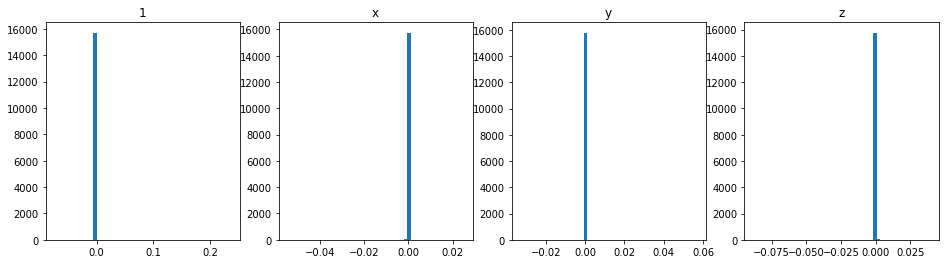

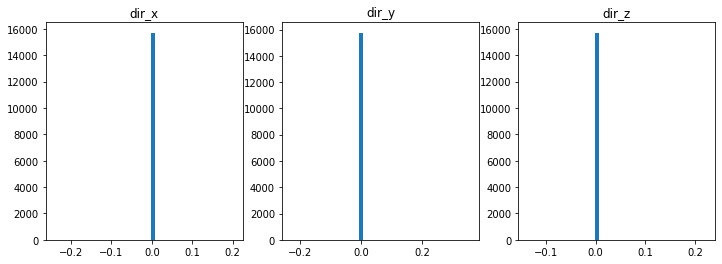

tensor([0.0053, 0.0010, 0.0016, 0.0012, 0.0080, 0.0112, 0.0088])


In [10]:
# plot distribution of values
coords_1d = tayloredInput[ev,:,:,:].reshape([tayloredInput.shape[1],-1])

# Make 1D histogram
ev=0
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,4),facecolor='w')
ax0.hist(coords_1d[0,:],bins=50); ax0.set_title('1')
ax1.hist(coords_1d[1,:],bins=50); ax1.set_title('x')
ax2.hist(coords_1d[2,:],bins=50); ax2.set_title('y')
ax3.hist(coords_1d[3,:],bins=50); ax3.set_title('z')
plt.show()

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12,4),facecolor='w')
ax0.hist(coords_1d[4,:],bins=50); ax0.set_title('dir_x')
ax1.hist(coords_1d[5,:],bins=50); ax1.set_title('dir_y')
ax2.hist(coords_1d[6,:],bins=50); ax2.set_title('dir_z')
plt.show()

print(torch.std(coords_1d,1))

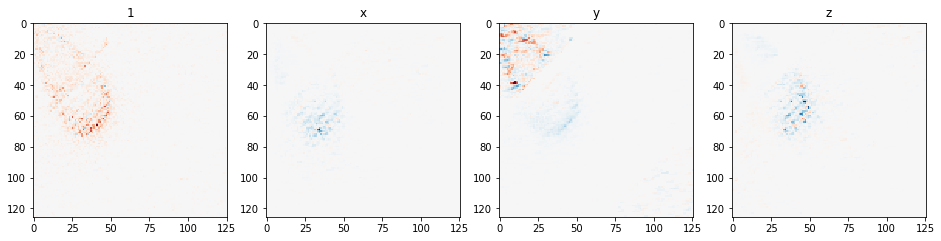

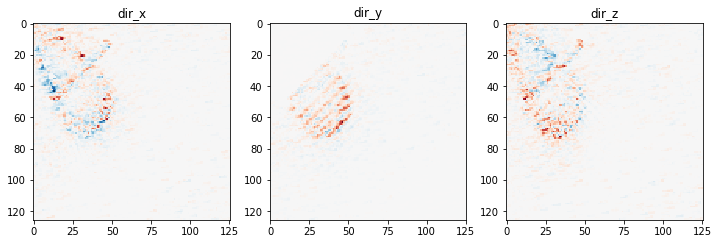

In [12]:
ev=2
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,0,:,:]); ax0.set_title('1')
imshowRdBu(ax1, tayloredInput[ev,1,:,:]); ax1.set_title('x')
imshowRdBu(ax2, tayloredInput[ev,2,:,:]); ax2.set_title('y')
imshowRdBu(ax3, tayloredInput[ev,3,:,:]); ax3.set_title('z')
plt.show()

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,4,:,:]); ax0.set_title('dir_x')
imshowRdBu(ax1, tayloredInput[ev,5,:,:]); ax1.set_title('dir_y')
imshowRdBu(ax2, tayloredInput[ev,6,:,:]); ax2.set_title('dir_z')
plt.show()

In [15]:
class TaylorConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout):
        super(TaylorConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.conv2d = torch.nn.Conv2d(Cin*Ntaylor,Cout,1)
        self.AA = tGridAA.clone()
        # 1x1 convolution since the neighbor information is encoded in the additional channels out Ntaylor
 
    def forward(self, x):
        Nbatch = x.shape[0]
        Hin = x.shape[2]
        Win = x.shape[3]
        
        inputsPad = geometricPad(x, pad); # (B,C,W,H)
        tayloredInput = x.new_zeros((Nbatch,Ntaylor,self.Cin,Hin,Win))
        for k in range(Ntaylor):
            # shift grid according to position (without copying the data)
            inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
            inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
            # fill
            out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', self.AA[:,:,:,k], inputsPadD2))
            tayloredInput = out

        tayloredInput = tayloredInput.view(Nbatch, Ntaylor*self.Cin, Hin, Win)
        return self.conv2d(tayloredInput)
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorConv2d, self).cpu()
        self.AA.cpu()
        return self
    
    def cuda(self):
        super(TaylorConv2d, self).cuda()
        self.AA = self.AA.cuda()
        return self


class GeomConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout):
        super(GeomConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*pad+1)
 
    def forward(self, x):
        Nbatch = x.shape[0]
        Hin = x.shape[2]
        Win = x.shape[3]
        
        inputsPad = geometricPad(x, pad); # (B,C,W,H)
        return self.conv2d(inputsPad)


class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            #TaylorConv2d( 2,16), torch.nn.ReLU(),
            #TaylorConv2d(16,32), torch.nn.ReLU(),
            
            # geom conv
            #GeomConv2d( 2,16), torch.nn.ReLU(),
            #GeomConv2d(16,32), torch.nn.ReLU(),
            
            # ordinary conv
            torch.nn.Conv2d( 2,16,3,padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(32,32), torch.nn.ReLU(),
            #torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,32))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(CNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(CNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [16]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(3).cuda() # construct CNN for 3 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [17]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        # mse        = blob.mse(prediction,label).cpu().detach().numpy()
        # accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

H5Dataset from https://github.com/WatChMaL/ExampleNotebooks/blob/master/HKML%20DataLoader.ipynb

In [18]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        return fh['event_data'][entry_index],label,idx
        #return fh['event_data'][entry_index],np.stack([np.sum(fh['energies'][entry_index,:])]),idx
        #labels = (fh['energies'][entry_index,0]>500.)-0
        #return fh['event_data'][entry_index],labels,idx

In [19]:
#f.close()
#f1Re.close()
#f1Rpip.close()

18000 total events are loaded!
Entry 0 ... label: 0 ... data shape: (126, 126, 2)


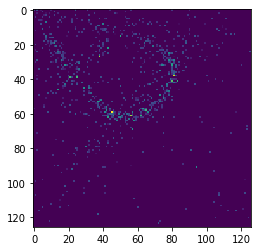

In [24]:
mcdir = '/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo'
pnames = ('e-','mu-')
ds = H5Dataset(['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+1) for bch in [100,101,102] for pname in pnames])
print(len(ds),'total events are loaded!')

ENTRY = 0
# Access an index
data,label,idx = ds[ENTRY]
# Data shape
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
# Visualize
plt.imshow(data[:,:,0])
plt.show()

In [25]:
def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

In [26]:
loader = DataLoader(ds,
                    batch_size=5,  # set the batch size = 50
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )
#time_record = loop(loader,10)
#print('Overall average iteration time:',time_record.mean(),'[s]')
#print('First event     iteration time:',time_record[0],    '[s]')
#print('After first event average time:',time_record[1:].mean(),'[s]')

(5, 126, 126, 2) [0, 0, 0, 1, 1]


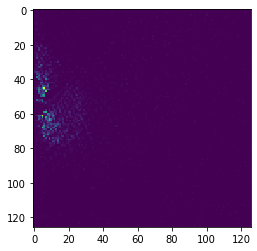

In [30]:
for i,data in enumerate(loader):
    break

print(data[0].shape, data[1])

plt.imshow(data[0][0,:,:,0])
plt.show()

In [31]:
import time

# Set the network to training mode
blob.net.train()
train_loader = loader

# Start training
for i,data in enumerate(train_loader):
    break

# Data and label
blob.data,blob.label = data[0:2]
# Call forward: make a prediction & measure the average error
res = forward(blob,True)
# Call backward: backpropagate error and update weights


In [32]:
res

{'prediction': array([0, 0, 0, 0, 1]),
 'softmax': array([[0.37529412, 0.33642453, 0.28828135],
        [0.55855   , 0.19282515, 0.2486249 ],
        [0.5591741 , 0.13578935, 0.30503651],
        [0.35598907, 0.34176895, 0.30224198],
        [0.35168967, 0.37865067, 0.26965967]], dtype=float32),
 'loss': 1.0722817182540894,
 'accuracy': 0.4}

In [33]:
blob.optimizer.zero_grad()  # Reset gradients accumulation
#blob.loss.backward()
#blob.optimizer.step()

In [34]:
blob.loss.backward()

In [35]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(2).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis
blob.prefix = "20200629-IWCD-test-01-CNN"

In [37]:
mcdir = '/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo'
pnames = ('e-','mu-')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(30) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [38]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2020-06-29 20:18:03


Epoch 1 Starting @ 2020-06-29 20:20:06


Epoch 2 Starting @ 2020-06-29 20:22:13


Epoch 3 Starting @ 2020-06-29 20:24:21


Unknown label 0 for entry_index 2980 treating as label=0
Epoch 4 Starting @ 2020-06-29 20:26:28


Epoch 5 Starting @ 2020-06-29 20:28:37


Epoch 6 Starting @ 2020-06-29 20:30:45


Epoch 7 Starting @ 2020-06-29 20:32:53


Epoch 8 Starting @ 2020-06-29 20:35:01


Epoch 9 Starting @ 2020-06-29 20:37:10


In [39]:
blob.test_log.close()
blob.train_log.close()

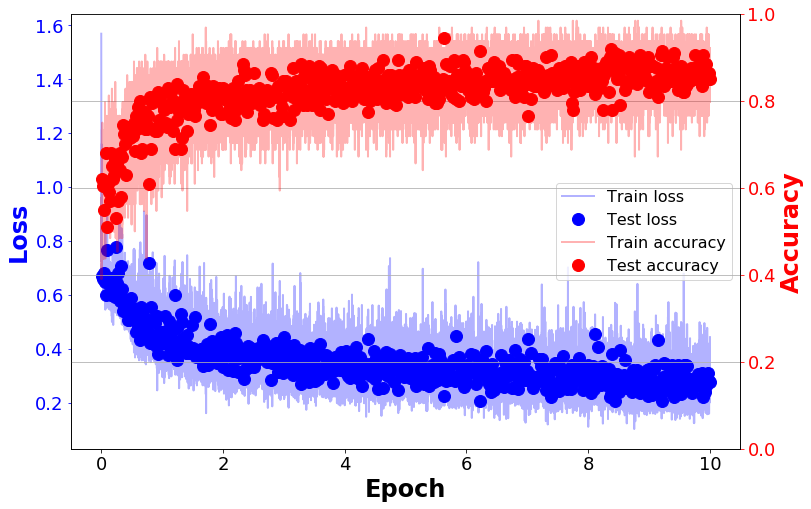

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

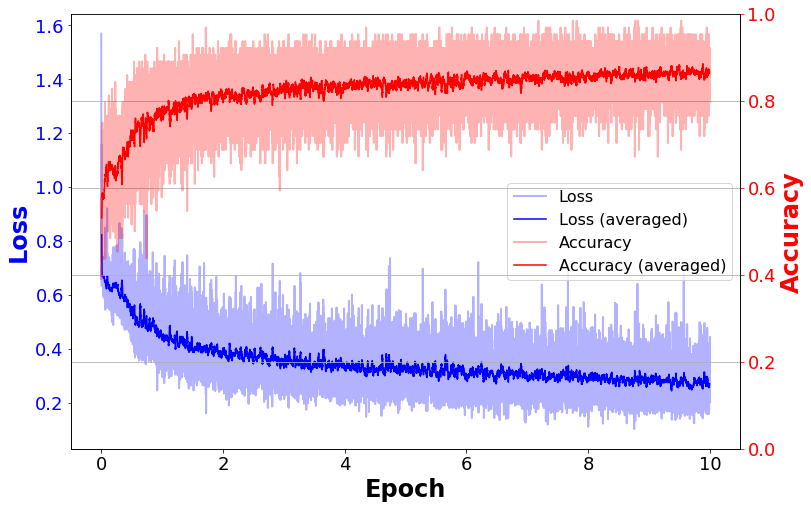

In [41]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [42]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

Accuracy mean 0.8653333 std 0.024264738


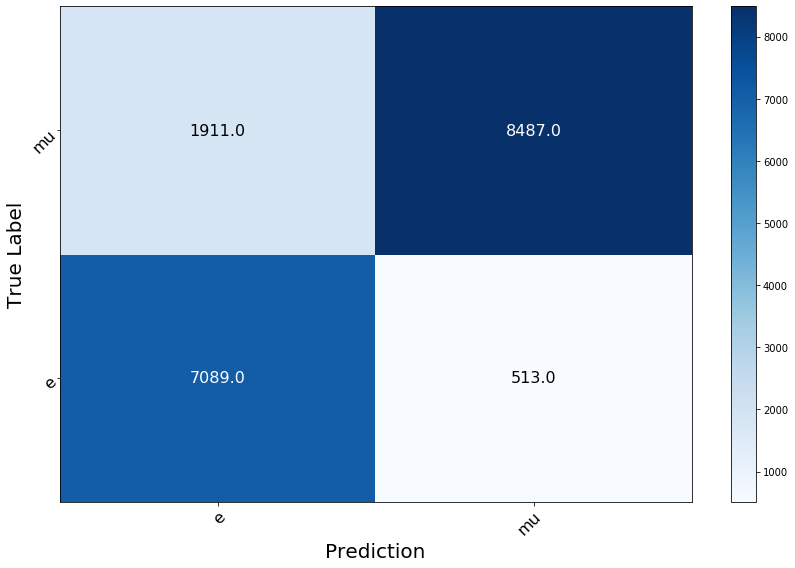

In [43]:
from utils.utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['e','mu'])

I think "True Label" and "Prediction" is swapped

In [60]:
def inferenceWithSoftmax(blob,data_loader):
    label,prediction,accuracy,softmax=[],[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        softmax.append(res['softmax'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    softmax    = np.vstack(softmax)
    
    return accuracy, label, prediction, softmax

In [61]:
accuracy,label,prediction,softmax = inferenceWithSoftmax(blob,test_loader)

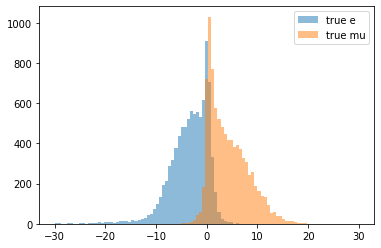

In [77]:
# plt.hist(coords_1d[0,:],bins=50)

# plt.hist(np.log(softmax[:,1]/softmax[:,0]))
#plt.hist(np.log((softmax[:,1]/softmax[:,0])[label == 0]),bins=50);

bins = np.linspace(-30, 30, 100)

plt.hist(np.log((softmax[:,1]/softmax[:,0])[label == 0]), bins, alpha=0.5, label='true e')
plt.hist(np.log((softmax[:,1]/softmax[:,0])[label == 1]), bins, alpha=0.5, label='true mu')
plt.legend(loc='upper right')
plt.show()

In [78]:
def save_state(blob):
    # Output file name
    filename = '%s-%d.ckpt' % (blob.prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_epoch': blob.epoch,
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, iteration):
    # Open a file in read-binary mode
    weight_file = '%s-%d.ckpt' % (blob.prefix, iteration)
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.epoch     = checkpoint['global_epoch']
        blob.iteration = checkpoint['global_step']

In [83]:
blob.epoch = epoch
blob.iteration = iteration
save_state(blob)

'20200629-IWCD-test-01-CNN-25320.ckpt'

In [84]:
class GeomCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(GeomCNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            #TaylorConv2d( 2,16), torch.nn.ReLU(),
            #TaylorConv2d(16,32), torch.nn.ReLU(),
            
            # geom conv
            GeomConv2d( 2,16), torch.nn.ReLU(),
            GeomConv2d(16,32), torch.nn.ReLU(),
            
            # ordinary conv
            #torch.nn.Conv2d( 2,16,3,padding=1), torch.nn.ReLU(),
            #torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(32,32), torch.nn.ReLU(),
            #torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,32))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(GeomCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(GeomCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [85]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = GeomCNN(2).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis
blob.prefix = "20200629-IWCD-test-02-GeomCNN"

In [86]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train_%s.csv' % blob.prefix), CSVData('log_test_%s.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2020-06-29 21:02:18


Epoch 1 Starting @ 2020-06-29 21:04:51


Epoch 2 Starting @ 2020-06-29 21:07:26


Epoch 3 Starting @ 2020-06-29 21:10:01


Epoch 4 Starting @ 2020-06-29 21:12:37


Epoch 5 Starting @ 2020-06-29 21:15:13


Epoch 6 Starting @ 2020-06-29 21:17:49


Epoch 7 Starting @ 2020-06-29 21:20:22


Epoch 8 Starting @ 2020-06-29 21:22:56


Epoch 9 Starting @ 2020-06-29 21:25:32


Unknown label -1083519927 for entry_index 2880 treating as label=0


In [120]:
blob.epoch = epoch
blob.iteration = iteration
save_state(blob)

'20200629-IWCD-test-02-GeomCNN-25320.ckpt'

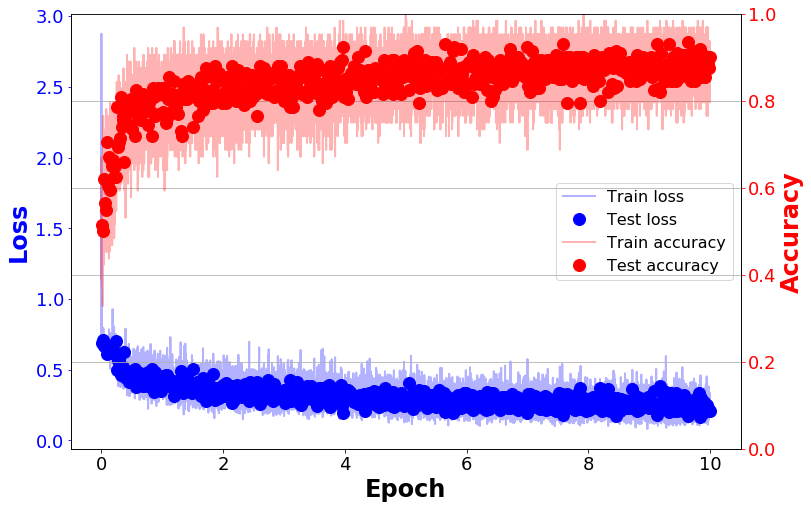

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

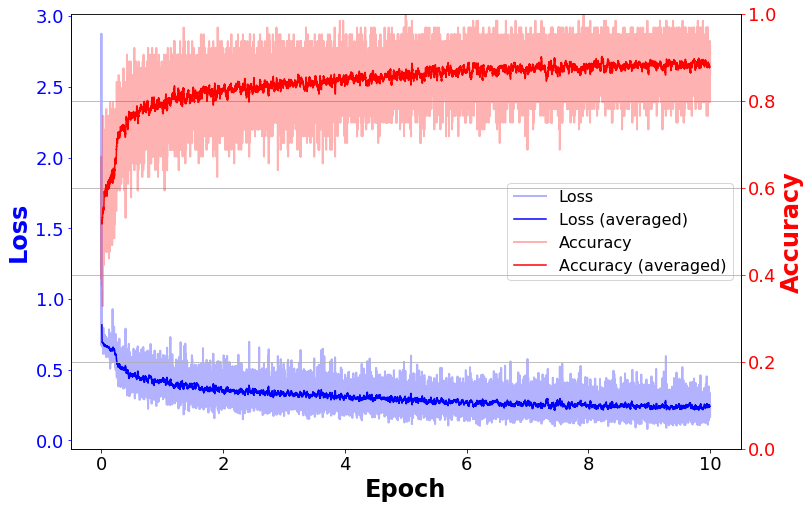

In [92]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

Accuracy mean 0.8857223 std 0.022280548


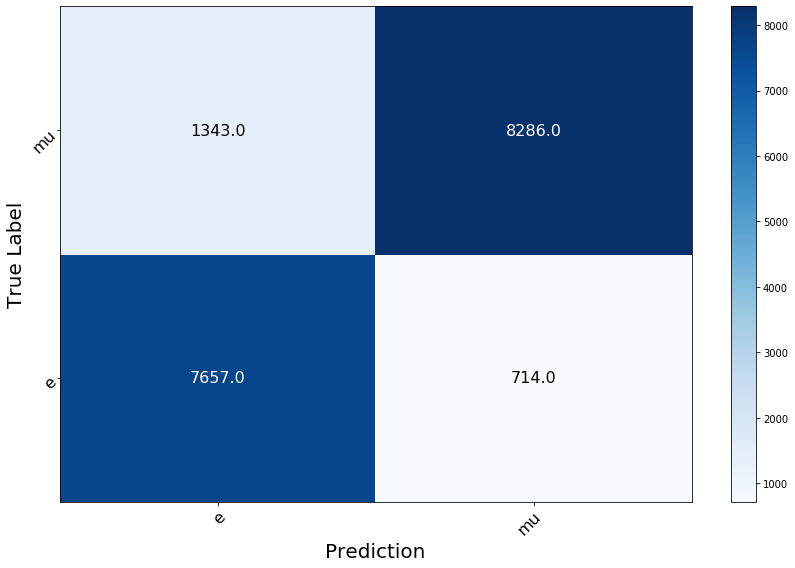

In [89]:
from utils.utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['e','mu'])

In [90]:
accuracy,label,prediction,softmax = inferenceWithSoftmax(blob,test_loader)

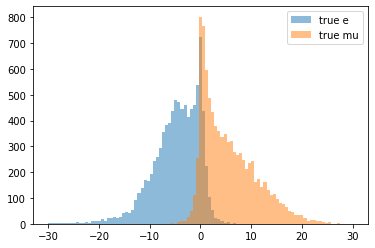

In [91]:
bins = np.linspace(-30, 30, 100)

plt.hist(np.log((softmax[:,1]/softmax[:,0])[label == 0]), bins, alpha=0.5, label='true e')
plt.hist(np.log((softmax[:,1]/softmax[:,0])[label == 1]), bins, alpha=0.5, label='true mu')
plt.legend(loc='upper right')
plt.show()

In [98]:
llr_order = np.argsort(np.log(softmax[:,1]/softmax[:,0]))
cumsum_true0 = np.cumsum((label == 0)[llr_order]) / np.sum(label == 0)
cumsum_true1 = np.cumsum((label == 1)[llr_order]) / np.sum(label == 1)

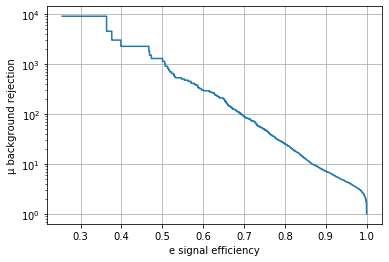

In [119]:
plt.plot(cumsum_true0[cumsum_true1>0], 1./cumsum_true1[cumsum_true1>0])
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("e signal efficiency")
plt.ylabel("μ background rejection")
plt.grid()
plt.show()

In [121]:
class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(TaylorCNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            TaylorConv2d( 2,16), torch.nn.ReLU(),
            TaylorConv2d(16,32), torch.nn.ReLU(),
            
            # geom conv
            #GeomConv2d( 2,16), torch.nn.ReLU(),
            #GeomConv2d(16,32), torch.nn.ReLU(),
            
            # ordinary conv
            #torch.nn.Conv2d( 2,16,3,padding=1), torch.nn.ReLU(),
            #torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(32,32), torch.nn.ReLU(),
            #torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,32))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [122]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(2).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis
blob.prefix = "20200629-IWCD-test-03-TaylorCNN"

In [123]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train_%s.csv' % blob.prefix), CSVData('log_test_%s.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2020-06-29 22:25:14


Epoch 1 Starting @ 2020-06-29 22:32:49


Epoch 2 Starting @ 2020-06-29 22:40:25


Epoch 3 Starting @ 2020-06-29 22:47:59


Epoch 4 Starting @ 2020-06-29 22:55:39


Epoch 5 Starting @ 2020-06-29 23:03:16


Epoch 6 Starting @ 2020-06-29 23:10:52


Epoch 7 Starting @ 2020-06-29 23:18:25


Epoch 8 Starting @ 2020-06-29 23:26:00


Epoch 9 Starting @ 2020-06-29 23:33:34


Unknown label 0 for entry_index 2916 treating as label=0


In [149]:
blob.epoch = epoch
blob.iteration = iteration
save_state(blob)

'20200629-IWCD-test-03-TaylorCNN-25320.ckpt'

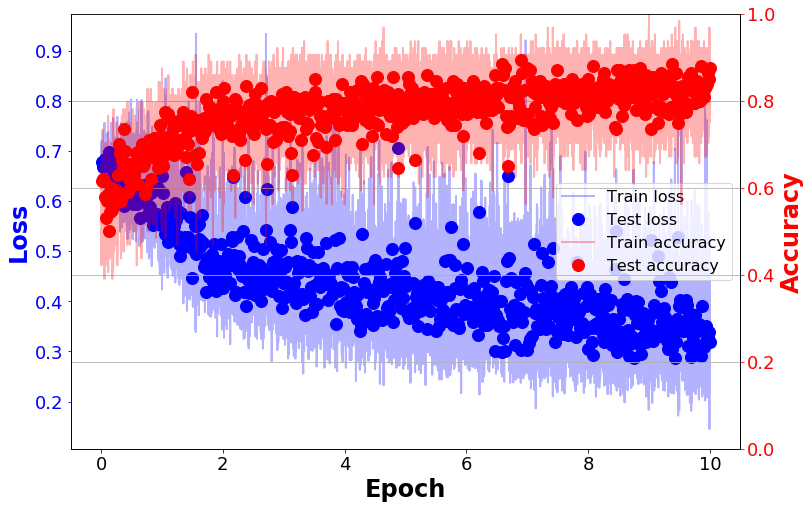

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

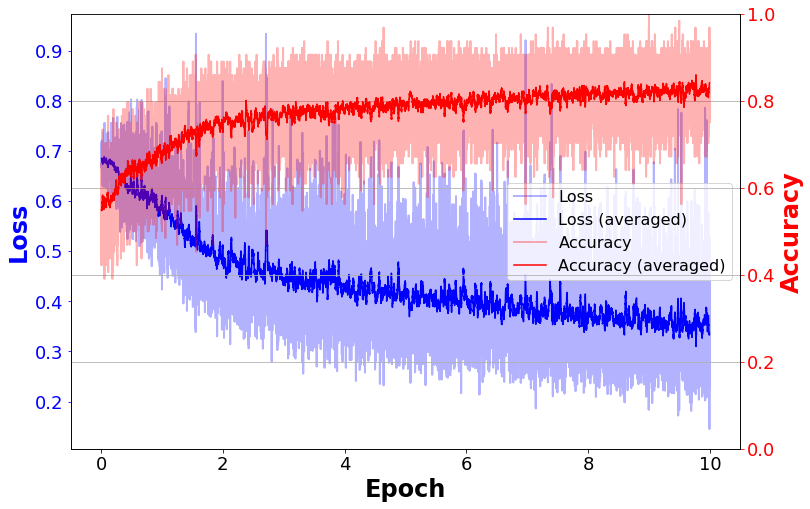

In [125]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [128]:
torch.cuda.empty_cache()
# doesn't seem to help

In [141]:
# let's reduce the batch size for test_loader
test_loader = DataLoader( test_ds,batch_size=40,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [137]:
blob.optimizer.zero_grad()  # Reset gradients accumulation
blob.loss = 0

In [138]:
from __future__ import print_function  # for Python2
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

__name__ 57
__doc__ 113
__package__ 16
__loader__ 16
__spec__ 16
__builtin__ 88
__builtins__ 88
_ih 1256
_oh 1192
_dh 80
In 1256
Out 1192
get_ipython 72
exit 64
quit 64
_ 89
__ 104
___ 104
_i 121
_ii 124
_iii 128
_i1 60
h5py 88
_i2 240
f 64
event_data 381024144
_i3 105
print_function 64
np 88
_i4 57
_4 72
_i5 99
plt 88
_i6 475
fig 64
ax0 64
ax1 64
ax2 64
ax3 64
_i7 704
torch 88
geometricPad 144
_i8 3060
pad 28
mGridPmt 63616
mGridCoord 762176
Ncoords 28
M 28
mGridI 112
mGridJ 112
Nshift 28
dij 112
dis 296
djs 296
Nsites 28
mGridPmtpad 112
mGridIpad 112
mGridJpad 112
mGridCoordPad 128
mGridAA2 22226560
pmtI1 112
x 19051344
skip 397028
processedPmtI2s 3175328
diji 28
di 32
dj 32
i2 112
j2 112
pmtI2 112
prev_diji 28
X 22226544
Lambda 24
MA 79380144
k 28
j 28
AA 22226544
_i9 2139
mGridAA 22226544
Cin 28
Hin 28
Win 28
inputs 80
inputsPad 80
Nbatch 28
Ntaylor 28
tGridAA 80
tayloredInput 80
inputsPadD1 80
inputsPadD2 80
out 80
imshowRdBu 144
ev 28
_i10 758
coords_1d 80
_i11 659
_i12 659
_i13 

In [139]:
del cumsum_true0
del cumsum_true1
del llr_true0
del llr_true1
del inferenceWithSoftmax
del softmax
del accuracy
del prediction
del event_data_1Rmu
del event_data

In [140]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([200, 2])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 2, 126, 126])
<class 'torch.Tensor'> torch.Size([200, 16, 126, 126])
<class 'torch.Tensor'> torch.Size([200, 16, 130, 130])
<class 'torch.Tensor'> torch.Size([200, 7, 16, 126, 126])
<class 'torch.Tensor'> torch.Size([200, 16, 126, 130])
<class 'torch.Tensor'> torch.Size([200, 16, 126, 126])
<class 'torch.Tensor'> torch.Size([7, 126, 126])
<class 'torch.Tensor'> torch.Size([130, 130])
<class 'torch.Tensor'> torch.Size([130, 130])
<class 'torch.Tensor'> torch.Size([130, 130])
<class 'torch.Tensor'> torch.Size([6, 130, 130])
<class 'torch.Tensor'> torch.Size([5, 1, 126, 126])
<class 'torch.Tensor'> torch.Size([5, 1, 130, 130])
<class 'torch.Tensor'> torch.Size([7, 126, 126, 25])
<class 'torch.Tensor'> torch.Size([5, 1, 126, 130])
<class 'torch.Tensor'> torch.Size([5, 1, 126, 126])
<class 'torch.Tensor'> torch.Size([5, 7, 1, 126, 126])
<class 'torch.Tensor'> torch.Si

/usr/lib/anaconda3/lib/python3.7/importlib/__init__.py:127: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/lib/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:102: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In [142]:
# inference should be running with train=False

def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,train=False)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

Accuracy mean 0.8211111 std 0.060220785


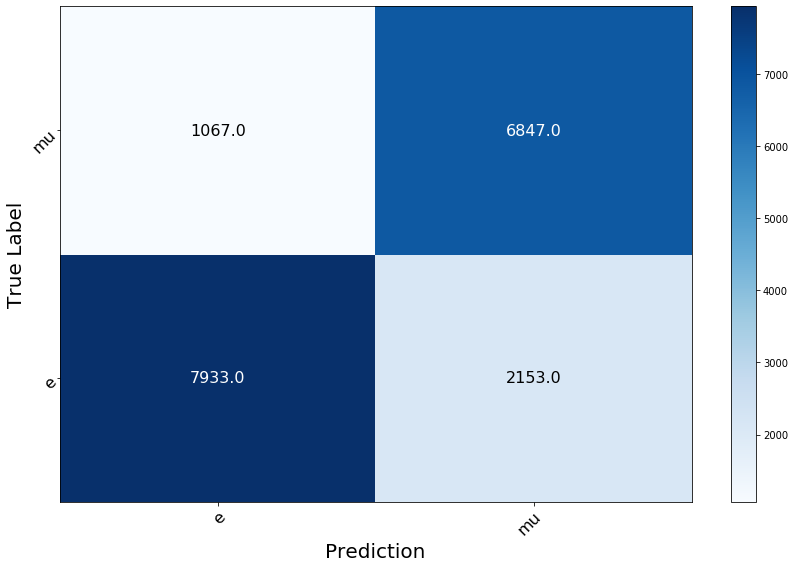

In [143]:
from utils.utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['e','mu'])

In [144]:
# here we also redefine such that train=False

def inferenceWithSoftmax(blob,data_loader):
    label,prediction,accuracy,softmax=[],[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,train=False)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        softmax.append(res['softmax'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    softmax    = np.vstack(softmax)
    
    return accuracy, label, prediction, softmax

In [145]:
accuracy,label,prediction,softmax = inferenceWithSoftmax(blob,test_loader)

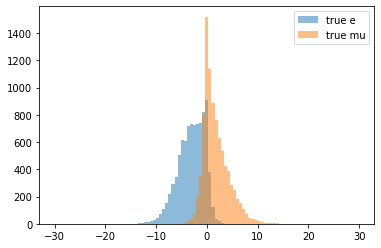

In [146]:
bins = np.linspace(-30, 30, 100)

plt.hist(np.log((softmax[:,1]/softmax[:,0])[label == 0]), bins, alpha=0.5, label='true e')
plt.hist(np.log((softmax[:,1]/softmax[:,0])[label == 1]), bins, alpha=0.5, label='true mu')
plt.legend(loc='upper right')
plt.show()

In [147]:
llr_order = np.argsort(np.log(softmax[:,1]/softmax[:,0]))
cumsum_true0 = np.cumsum((label == 0)[llr_order]) / np.sum(label == 0)
cumsum_true1 = np.cumsum((label == 1)[llr_order]) / np.sum(label == 1)

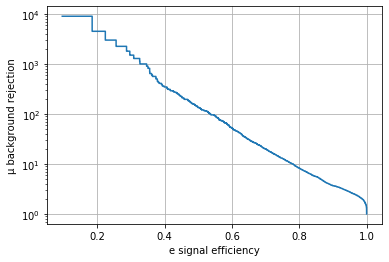

In [148]:
plt.plot(cumsum_true0[cumsum_true1>0], 1./cumsum_true1[cumsum_true1>0])
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("e signal efficiency")
plt.ylabel("μ background rejection")
plt.grid()
plt.show()